In [5]:
import pandas as pd
import numpy as np 
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from feature_engine.encoding import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from feature_engine.wrappers import SklearnTransformerWrapper

from sklearn import set_config

import graphviz
import pydotplus

set_config(display='diagram')

In [2]:
data = {'Salud': ['Enfermo', 'Enfermo', 'No enfermo', 'No enfermo', 'No enfermo', 'Enfermo', 'No enfermo', 'No enfermo'],
        'Temperatura': ['Baja', 'Alta', 'Baja', 'Baja', 'Alta', 'Alta', 'Baja', 'Alta'],
        'Salir': ['N', 'S', 'S', 'N', 'S', 'N', 'N', 'S']}

df = pd.DataFrame(data)
df


,Salud,Temperatura,Salir
0,Enfermo,Baja,N
1,Enfermo,Alta,S
2,No enfermo,Baja,S
3,No enfermo,Baja,N
4,No enfermo,Alta,S
5,Enfermo,Alta,N
6,No enfermo,Baja,N
7,No enfermo,Alta,S


In [6]:
ord = OrdinalEncoder(encoding_method='arbitrary')
df_new = ord.fit_transform(df)
df_new

,Salud,Temperatura,Salir
0,0,0,0
1,0,1,1
2,1,0,1
3,1,0,0
4,1,1,1
5,0,1,0
6,1,0,0
7,1,1,1


In [9]:
X = df_new.drop(columns='Salir')
y = df_new.Salir

## Voy a utilizar el árbol de decisión como un modelo explicativo... quiero entender la estructura de la data

dt = DecisionTreeClassifier(random_state=123)

dt.fit(X,y)

DecisionTreeClassifier(random_state=123)

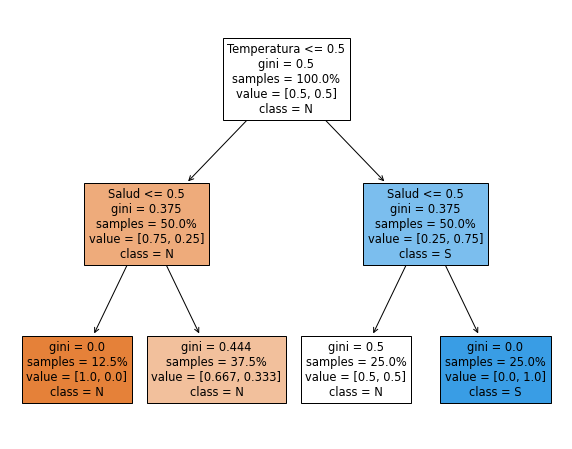

In [11]:
## Gran Ventaja es que son altamente explicativos...

plt.figure(figsize=(10,8))
plot_tree(dt, feature_names=X.columns, class_names = ['N', 'S'], filled = True, proportion=True);


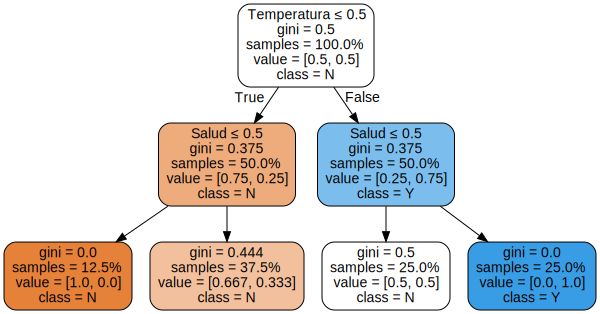

In [12]:
def plot_dt(model, features, classes):
    dot_data = export_graphviz(model, out_file=None,
                               feature_names=features,
                               class_names=classes,
                               filled=True, rounded=True,
                               special_characters=True,
                               proportion=True)
    return graphviz.Source(dot_data)


plot_dt(dt, X.columns, ['N', 'Y'])


In [13]:
## Es bueno usar un árbol de decisión... para explicar sí, para predicir... No (siempre sobreajusta): Regularizar el árbol...add()

df = pd.read_csv('iris.csv')

X = df.drop(columns='class')
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)



## Regularización

* Pre_prunning: Evitando que el árbol crezca...(no le voy a permitir crecer...)
    * max_depth: controla número de niveles ... complejidad
    * min_samples_split: Regularización
    * min_samples_leaf: Regularización, numero mínimo de datos para que sea hoja...
    * min_impurity_decrease: Regularización, exijo un cierto decremento en la impureza
* Post-prunning: Una vez que el árbol termino yo le corto ciertas partes...
    * ccp_alpha: Cost complexity prunning... Mas chico es menos regularización

                 precision    recall  f1-score   support

    Iris-setosa     1.0000    1.0000    1.0000        32
Iris-versicolor     0.9750    0.9750    0.9750        40
 Iris-virginica     0.9697    0.9697    0.9697        33

       accuracy                         0.9810       105
      macro avg     0.9816    0.9816    0.9816       105
   weighted avg     0.9810    0.9810    0.9810       105

                 precision    recall  f1-score   support

    Iris-setosa     1.0000    1.0000    1.0000        18
Iris-versicolor     0.8333    1.0000    0.9091        10
 Iris-virginica     1.0000    0.8824    0.9375        17

       accuracy                         0.9556        45
      macro avg     0.9444    0.9608    0.9489        45
   weighted avg     0.9630    0.9556    0.9562        45



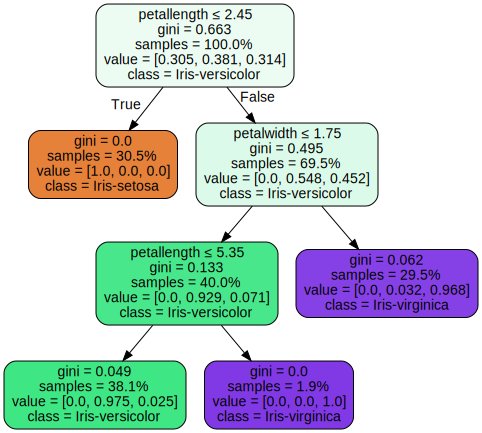

In [44]:
dt = DecisionTreeClassifier(random_state=123, 
                            # max_depth=5, 
                            # min_samples_split=0.3,
                            # min_samples_leaf=.2, 
                            # min_impurity_decrease=.01,
                            ccp_alpha = .02
                            )
dt.fit(X_train,y_train)

y_pred = dt.predict(X_test)
y_pred_train = dt.predict(X_train)
print(classification_report(y_train, y_pred_train, digits=4))
print(classification_report(y_test, y_pred, digits=4))
plot_dt(dt, X.columns, df['class'].unique())


In [45]:
df = pd.read_csv('titanic.csv', index_col=0).drop(columns=['Signing_date','Cabin','Ticket','Name'])
X = df.drop(columns=['Survived'])
y = df.Survived
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


## Pipeline de Preprocesamiento

In [47]:
from feature_engine.imputation import CategoricalImputer, MeanMedianImputer
prep = Pipeline(steps=[
    ('cat_imp', CategoricalImputer(imputation_method='frequent')),
    ('num_imp', MeanMedianImputer(imputation_method='mean')),
    ('ohe', OneHotEncoder(drop_last = True)),
    ('sc', SklearnTransformerWrapper(StandardScaler(), variables=['Age','Fare', 'SibSp','Parch']))
])

prep.fit_transform(X_train)

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Embarked_C,Embarked_Q
PassengerId,,,,,,,,
330,1,-1.086485,-0.460103,0.829588,0.490420,1,1,0
750,3,0.091668,-0.460103,-0.474312,-0.472168,0,0,1
204,3,1.230549,-0.460103,-0.474312,-0.482229,0,1,0
422,3,-0.693768,-0.460103,-0.474312,-0.472488,0,0,1
98,1,-0.536681,-0.460103,0.829588,0.593505,0,1,0
...,...,...,...,...,...,...,...,...
99,2,0.327298,-0.460103,0.829588,-0.179919,1,0,0
323,2,0.013124,-0.460103,-0.474312,-0.384014,1,0,1
383,3,0.170211,-0.460103,-0.474312,-0.468815,0,0,0


In [52]:
pipe = Pipeline(steps = [
    ('prep', prep),
    ('dt', DecisionTreeClassifier(random_state=123))
])

params = {'prep__sc': [SklearnTransformerWrapper(StandardScaler(), variables=['Age','Fare', 'SibSp','Parch']), 'passthrough'],
        'prep__num_imp__imputation_method': ['mean','median'] ,
        'prep__ohe':[OneHotEncoder(drop_last=True),OneHotEncoder(drop_last=False),OrdinalEncoder(encoding_method='ordered')],
        'prep__cat_imp__imputation_method':['frequent','missing'],
        'dt__ccp_alpha':[.01, .1, .2, .3, .4, .5],
        'dt__min_samples_split': np.arange(0.1, 1, 0.1),
        'dt__max_depth':[5, 10, 15]
        }

search = GridSearchCV(pipe, params, cv = 5, scoring='accuracy', n_jobs=-1)
search.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        Pipeline(steps=[('cat_imp',
                                                         CategoricalImputer(imputation_method='frequent')),
                                                        ('num_imp',
                                                         MeanMedianImputer(imputation_method='mean')),
                                                        ('ohe',
                                                         OneHotEncoder(drop_last=True)),
                                                        ('sc',
                                                         SklearnTransformerWrapper(transformer=StandardScaler(),
                                                                                   variables=['Age',
                                                                                              'Fare',
                                                                                              'SibSp',
                                                                                              'Parch']))])),
                                       ('dt',
                                        DecisionTreeCl...
                         'dt__min_samples_split': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'prep__cat_imp__imputation_method': ['frequent',
                                                              'missing'],
                         'prep__num_imp__imputation_method': ['mean', 'median'],
                         'prep__ohe': [OneHotEncoder(drop_last=True),
                                       OneHotEncoder(), OrdinalEncoder()],
                         'prep__sc': [SklearnTransformerWrapper(transformer=StandardScaler(),
                                                                variables=['Age',
                                                                           'Fare',
                                                                           'SibSp',
                                                                           'Parch']),
                                      'passthrough']},
             scoring='accuracy')

In [50]:
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.058776,0.000969,0.021949,0.001684,{},0.769231,0.748252,0.788732,0.78169,0.739437,0.765468,0.018935,1


In [54]:
search.best_score_

0.792159952723333

In [53]:
search.best_params_

{'dt__ccp_alpha': 0.01,
 'dt__max_depth': 5,
 'dt__min_samples_split': 0.4,
 'prep__cat_imp__imputation_method': 'frequent',
 'prep__num_imp__imputation_method': 'mean',
 'prep__ohe': OneHotEncoder(drop_last=True),
 'prep__sc': SklearnTransformerWrapper(transformer=StandardScaler(),
                           variables=['Age', 'Fare', 'SibSp', 'Parch'])}

<AxesSubplot:xlabel='param_dt__ccp_alpha'>

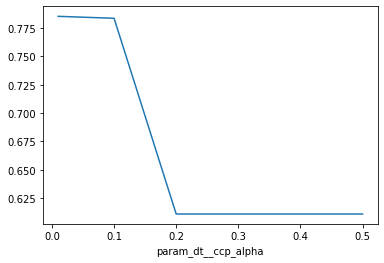

In [73]:
pd.DataFrame(search.cv_results_).groupby(
    'param_dt__ccp_alpha').mean_test_score.mean().plot()


In [103]:
pipe = Pipeline(steps = [
    ('prep', prep),
    ('dt', DecisionTreeClassifier(random_state=123))
])

params2 = {
        'dt__ccp_alpha': np.arange(0, 0.2, 0.05),
        'dt__min_samples_split': np.arange(0.34, 0.38, 0.001),
        'dt__max_depth': 5,
        }

search2 = GridSearchCV(pipe, params2, cv = 5, scoring='accuracy', n_jobs=-1)
search2.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        Pipeline(steps=[('cat_imp',
                                                         CategoricalImputer(imputation_method='frequent')),
                                                        ('num_imp',
                                                         MeanMedianImputer(imputation_method='mean')),
                                                        ('ohe',
                                                         OneHotEncoder(drop_last=True)),
                                                        ('sc',
                                                         SklearnTransformerWrapper(transformer=StandardScaler(),
                                                                                   variables=['Age',
                                                                                              'Fare',
                                                                                              'SibSp',
                                                                                              'Parch']))])),
                                       ('dt',
                                        DecisionTreeCl...
       0.345, 0.346, 0.347, 0.348, 0.349, 0.35 , 0.351, 0.352, 0.353,
       0.354, 0.355, 0.356, 0.357, 0.358, 0.359, 0.36 , 0.361, 0.362,
       0.363, 0.364, 0.365, 0.366, 0.367, 0.368, 0.369, 0.37 , 0.371,
       0.372, 0.373, 0.374, 0.375, 0.376, 0.377, 0.378, 0.379, 0.38 ,
       0.381, 0.382, 0.383, 0.384, 0.385, 0.386, 0.387, 0.388, 0.389,
       0.39 , 0.391, 0.392, 0.393, 0.394, 0.395, 0.396, 0.397, 0.398,
       0.399, 0.4  ])},
             scoring='accuracy')

In [104]:
search2.best_score_, search2.best_params_

(0.7935684034275583,
 {'dt__ccp_alpha': 0.0, 'dt__min_samples_split': 0.35100000000000003})

<AxesSubplot:xlabel='param_dt__min_samples_split'>

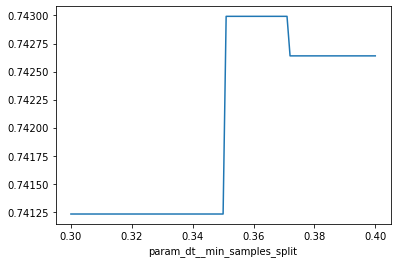

In [105]:
pd.DataFrame(search2.cv_results_).groupby(
    'param_dt__min_samples_split').mean_test_score.mean().plot()
